In [3]:
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
#data_path = '../outputs/models/generatedDigitalExps_1thFla_hier_by_room_rnn_meanPoolProc_cnn1d_video_2/test_output.json'

data_path = '../outputs/models/generatedDigitalExps_1tjR36_hier_by_room_rnn_meanPoolProc_video_2/test_output.json' # double loss

data_path_2 = '../outputs/models/generatedDigitalExps_1tjzS9_hier_by_room_rnn_meanPoolProc_video_2/test_output.json' # stl

with open(data_path) as f:
    data = json.load(f)

with open(data_path_2) as f:
    data_2 = json.load(f)

In [5]:
def get_index_of_best_try(data, metric_name):
    metrics = {i:el['metrics'][metric_name] for i,el in enumerate(data)}
    return max(metrics, key=metrics.get)

best_idx=get_index_of_best_try(data,'t2s_mAP_by_class')
print(best_idx)
desc = data[best_idx]['output_description_test']
museum = data[best_idx]['output_pov_test']
categories = data[best_idx]['output_categories']

X = np.concatenate([np.array(desc),np.array(museum)])

X.shape

1


(4000, 256)

In [6]:
best_idx_2=get_index_of_best_try(data,'t2s_mAP_by_class')
print(best_idx_2)
desc_2 = data_2[best_idx_2]['output_description_test']
museum_2 = data_2[best_idx_2]['output_pov_test']
categories_2 = data_2[best_idx_2]['output_categories']

X_2 = np.concatenate([np.array(desc_2),np.array(museum_2)])

X_2.shape

1


(4000, 256)

In [7]:
from datasets.digitalMuseumsSemArtVideoGenDataset.utils import DigitalMuseumsSemArtVideoGenDataset


In [8]:
import argparse
from src.utils.utils import *
import logging
import torch
from src.data.feature_utils import *
from src.evaluation.evaluation_utils import *
from src.training.train import *
from src.utils.data_utils import get_dataloaders
from src.models.models import EncodersExecutorConfig
from src.utils.model_utils import get_model_output_dir, PretrainedModelsCollection
from src.training.loss_functions import *

In [9]:
class Args():
    def __init__(self, feature_dir, feature_set_name, batch_size, num_workers):
        self.feature_dir = feature_dir
        self.feature_set_name = feature_set_name
        self.batch_size = batch_size
        self.num_workers = num_workers

args = Args('genMuseums', 'base_by_sentence_clip_32_fs', 2000, 1)

In [10]:
exhibitionDataset = DigitalMuseumsSemArtVideoGenDataset(skip_description_and_artworks_loading=True)
dataloaders = get_dataloaders(args, True, exhibitionDataset)
for b in dataloaders['test']:
    break

original_desc = [el.mean(axis=0) for el in torch.nn.utils.rnn.unpack_sequence(b[0])]
original_pov = b[1].mean(axis=1).tolist()
original_categories = b[-1]

original_pov_video = ((b[1].mean(axis=1) + b[3].mean(axis=1))/2).tolist()
original_categories[0:64]


tensor([5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
id_to_str_cat_map = {v:k[5:] for k,v in dataloaders['test'].dataset.all_museum_category_str_idx_map.items()}
id_to_str_cat_map

{0: 'genre',
 1: 'historical',
 2: 'interior',
 3: 'landscape',
 4: 'mythological',
 5: 'portrait',
 6: 'religious',
 7: 'still-life',
 8: 'study'}

In [12]:
from collections import Counter
c = Counter(categories)
{id_to_str_cat_map[k]:v for k,v in c.items()}

{'portrait': 349,
 'genre': 176,
 'historical': 79,
 'landscape': 317,
 'mythological': 180,
 'religious': 794,
 'still-life': 105}

In [13]:
id_to_str_cat_map

{0: 'genre',
 1: 'historical',
 2: 'interior',
 3: 'landscape',
 4: 'mythological',
 5: 'portrait',
 6: 'religious',
 7: 'still-life',
 8: 'study'}

In [14]:
cat_counter = Counter(categories)

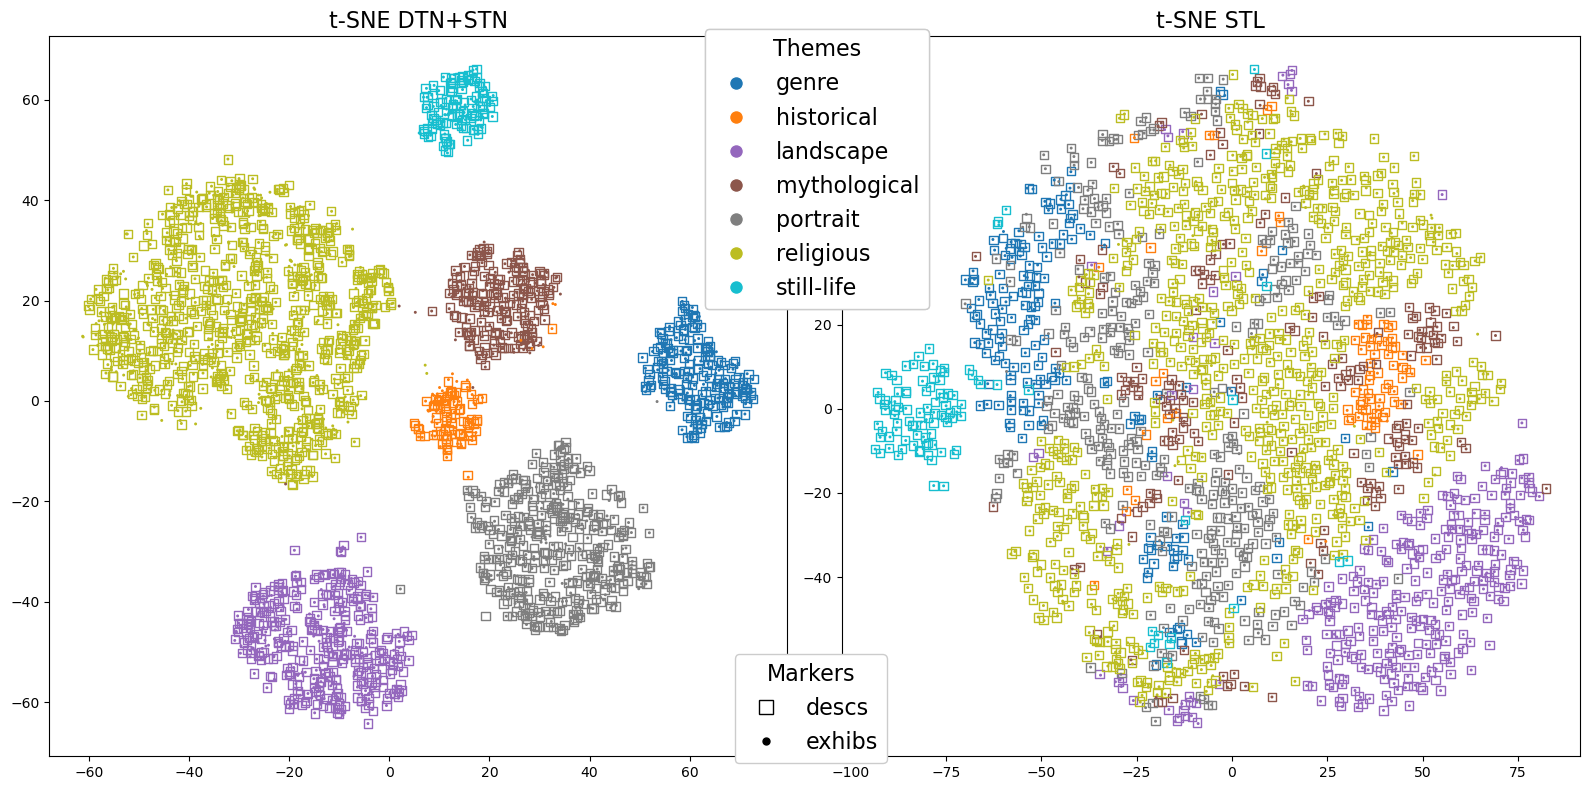

In [58]:

def plot_2d_pca_museum(ax, desc, museum, categories=None, title="PCA Plot"):
    pca = PCA(n_components=2, random_state=42)
    plot_2d_desc_museums(ax, pca, desc, museum, categories, title)
    return pca

def plot_2d_tsne_museum(ax, desc, museum, categories=None, title="t-SNE Plot"):
    tsne = TSNE(n_components=2, random_state=42, metric='cosine')
    plot_2d_desc_museums(ax, tsne, desc, museum, categories, title)
    return tsne


def plot_2d_desc_museums(ax, t_f, desc, museum, categories=None, title="2D Plot"):
    X = np.concatenate([np.array(desc) ,np.array(museum)])

    X_t = t_f.fit_transform(X)
    sep = len(desc)
    
    # Normalize categories to ensure consistent colormap mapping.
    norm = plt.Normalize(vmin=min(categories), vmax=max(categories))
    # Compute the edge colors using the tab10 colormap for each category.
    edgecolors = plt.cm.tab10(norm(np.array(categories)))
    
    # Plot the first scatter with empty square markers (facecolors='none')
    # and set the edgecolors to the computed colors.
    sc1 = ax.scatter(X_t[:sep, 0], X_t[:sep, 1],
                     marker='s', label='descs',
                     facecolors='none', edgecolors=edgecolors)
    
    # Plot the second scatter normally.
    sc2 = ax.scatter(X_t[sep:, 0], X_t[sep:, 1],
                     c=categories, cmap='tab10',
                     marker='.', label='exhibs',s=5)
    
    ax.set_title(title, fontsize=16)
    # ax.set_xlabel('Component 1')
    # ax.set_ylabel('Component 2')

# Set up the grid
l =8
fig, axs = plt.subplots(1, 2, figsize=(2*l, l))

# Plot t-SNE for current data
plot_2d_tsne_museum(axs[0], desc, museum, original_categories, title="t-SNE DTN+STN")
plot_2d_tsne_museum(axs[1], desc_2, museum_2, original_categories, title="t-SNE STL")
#plot_2d_pca_museum(ax, desc, museum, original_categories, title="PCA: Current Data")

# --- Create a legend for the marker types ---
marker_legend_elements = [
    plt.Line2D([0], [0], marker='s', color='black', linestyle='',
               label='descs', markerfacecolor='none', markersize=10),
    plt.Line2D([0], [0], marker='.', color='black', linestyle='',
               label='exhibs', markersize=10)
]

ax = axs[1]
# Place this legend in the lower left (for example)
marker_legend = ax.legend(handles=marker_legend_elements, loc='lower left', title="Markers",bbox_to_anchor=[-.16,-0.025], fontsize=16)
marker_legend.get_frame().set_alpha(None)
marker_legend.get_frame().set_facecolor('white')  # solid white background
marker_legend.get_title().set_fontsize('16') 
ax.add_artist(marker_legend)

# --- Create a second legend for the categories ---
# Normalize category values as in your scatter plot:
vmin = min(original_categories)
vmax = max(original_categories)
categories_dict = id_to_str_cat_map  
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=categories_dict[i],
               markerfacecolor=plt.cm.tab10((i - vmin) / (vmax - vmin)), markersize=10)
    for i in sorted(categories_dict.keys()) if cat_counter[i]>0
]
# Place this legend inside the axes, e.g. in the upper right.
category_legend = ax.legend(handles=legend_elements, title="Themes", loc='upper left', bbox_to_anchor=[-.2,1.025], fontsize=16)
category_legend.get_frame().set_alpha(None)
category_legend.get_frame().set_facecolor('white')  # solid white background
category_legend.get_title().set_fontsize('16') 
ax.add_artist(category_legend)

plt.tight_layout()
plt.show()


In [59]:
fig.savefig('tsne_2loss_vs_stl.pdf',bbox_inches='tight')